# Smoothing particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import smoothing_particles as sp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2024-10-24"

n_particles = 4
ordering = True
video_name = "23_05_23_3_1080"
x_bounds = [40, 1020]
y_bounds = [160, 1740]
x_zoom = [760, 1000]
y_zoom = [1500, 1720]

## Load tracked data

In [3]:
df_tracked = pd.read_csv("{}/clustered_{}.csv".format(output_path, video_name), low_memory=False)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,area_convex,area_filled,axis_major,axis_minor,eccentricity,euler_number,id_count,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,131.361102,277.047904,129.820192,282.752376,NaN,131.361102,277.047904,NaN,131.361102,277.047904,-0.284792,9039.0,12978.0,9050.0,196.579324,71.364684,0.931776,-38,4,NaN,NaN,NaN,False,False,False
1,1,0,456.948442,377.037307,457.656262,377.513295,0.0,503.000000,333.000000,0.627451,476.000000,345.000000,-1.279919,8631.0,12656.0,8636.0,165.988477,72.910703,0.898364,-22,4,NaN,NaN,NaN,False,False,False
2,2,0,164.068444,499.940035,167.470318,504.772246,NaN,164.068444,499.940035,NaN,164.068444,499.940035,0.738668,9789.0,12576.0,9829.0,187.418000,74.960595,0.916531,-20,4,NaN,NaN,NaN,False,False,False
3,3,0,1455.613066,823.843911,1456.773911,830.276236,0.0,1445.000000,738.000000,0.458824,1447.000000,749.000000,0.155444,9123.0,10618.0,9917.0,190.276157,68.388433,0.933177,-25,4,NaN,NaN,NaN,False,False,False


## Swapping mixed IDs

In [ ]:
# arg_list = [
#     # VIDEO 1
#     [0    , 1695 , 95, 18 * np.pi / 180, True ],
#     [1695 , 1716 , 95, 18 * np.pi / 180, False],
#     [1716 , 1858 , 95, 18 * np.pi / 180, True ],
#     [1858 , 1914 , 95, 18 * np.pi / 180, False],
#     [1914 , 2043 , 95, 18 * np.pi / 180, True ],
#     [2043 , 2096 , 95, 18 * np.pi / 180, False],
#     [2096 , 3982 , 95, 18 * np.pi / 180, True ],
#     [3982 , 4014 , 95, 18 * np.pi / 180, False],
#     [4014 , 8400 , 95, 18 * np.pi / 180, True ],
#     [8400 , 8441 , 95, 18 * np.pi / 180, False],
#     [8441 , 8452 , 95, 18 * np.pi / 180, True ],
#     [8452 , 8460 , 95, 18 * np.pi / 180, False],
#     [8460 , 30579, 95, 18 * np.pi / 180, True ],
#     [30579, 30584, 95, 18 * np.pi / 180, False],
#     [30584, 30727, 95, 18 * np.pi / 180, True ],
#     [30727, 30743, 95, 18 * np.pi / 180, False],
#     [30743, 35252, 95, 18 * np.pi / 180, True ],
#     [35252, 35322, 95, 18 * np.pi / 180, False],
#     [35322, 36520, 95, 18 * np.pi / 180, True ],  # Divide in two the video
#     VIDEO 2
#     [36520, 36522, 95, 18 * np.pi / 180, False],
#     [36522, 40002, 95, 18 * np.pi / 180, True ],
#     [40002, 40849, 95, 18 * np.pi / 180, False],  # A gap over frames (no tracking possible)
#     [40849, 41102, 95, 18 * np.pi / 180, True ],
#     [41102, 42504, 95, 18 * np.pi / 180, False],
#     [42504, 42675, 95, 18 * np.pi / 180, True ],
#     [42675, 48182, 95, 18 * np.pi / 180, False],  # Another problem with video (reflect of cockroach) (Another video)
#     VIDEO 3
#     [48182, 50000, 95, 18 * np.pi / 180, True ],
# ]

In [4]:
omega_threshold = 18 * np.pi / 180  # Angular velocity per frame (in degrees)
velocity_threshold = 95  # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
delta = 400

from importlib import reload
reload(sp)

arg_list = [
    # VIDEO 1
    [0    , 1695 , 95, 18 * np.pi / 180, True ],
    [1695 , 1716 , 95, 18 * np.pi / 180, False],
    [1716 , 1858 , 95, 18 * np.pi / 180, True ],
    [1858 , 1914 , 95, 18 * np.pi / 180, False],
    [1914 , 2043 , 95, 18 * np.pi / 180, True ],
    [2043 , 2096 , 95, 18 * np.pi / 180, False],
    [2096 , 3982 , 95, 18 * np.pi / 180, True ],
    [3982 , 4014 , 95, 18 * np.pi / 180, False],
    [4014 , 5000 , 95, 18 * np.pi / 180, True ],
    [5000 , 6000 , 95, 18 * np.pi / 180, True ],
    [6000 , 7000 , 95, 18 * np.pi / 180, True ],
    [7000 , 8400 , 95, 18 * np.pi / 180, True ],
    [8400 , 8441 , 95, 18 * np.pi / 180, False],
    [8441 , 8452 , 95, 18 * np.pi / 180, True ],
    [8452 , 8460 , 95, 18 * np.pi / 180, False],
    [8460 , 9000 , 95, 18 * np.pi / 180, True ],
    [9000 , 10000, 95, 18 * np.pi / 180, True ],
    [10000, 11000, 95, 18 * np.pi / 180, True ],
    [11000, 12000, 95, 18 * np.pi / 180, True ],
    [12000, 13000, 95, 18 * np.pi / 180, True ],
    [13000, 14000, 95, 18 * np.pi / 180, True ],
    [14000, 15000, 95, 18 * np.pi / 180, True ],
    [15000, 16000, 95, 18 * np.pi / 180, True ],
    [16000, 17000, 95, 18 * np.pi / 180, True ],
    [17000, 18000, 95, 18 * np.pi / 180, True ],
    [18000, 19000, 95, 18 * np.pi / 180, True ],
    [19000, 20000, 95, 18 * np.pi / 180, True ],
    [20000, 21000, 95, 18 * np.pi / 180, True ],
    [21000, 22000, 95, 18 * np.pi / 180, True ],
    [22000, 23000, 95, 18 * np.pi / 180, True ],
    [23000, 24000, 95, 18 * np.pi / 180, True ],
    [24000, 25000, 95, 18 * np.pi / 180, True ],
    [25000, 26000, 95, 18 * np.pi / 180, True ],
    [26000, 27000, 95, 18 * np.pi / 180, True ],
    [27000, 28000, 95, 18 * np.pi / 180, True ],
    [28000, 29000, 95, 18 * np.pi / 180, True ],
    [29000, 30000, 95, 18 * np.pi / 180, True ],
    [30000, 30579, 95, 18 * np.pi / 180, True ],
    [30579, 30584, 95, 18 * np.pi / 180, False],
    [30584, 30727, 95, 18 * np.pi / 180, True ],
    [30727, 30743, 95, 18 * np.pi / 180, False],
    [30743, 31252, 95, 18 * np.pi / 180, True ],
    [31252, 32252, 95, 18 * np.pi / 180, True ],
    [32252, 33252, 95, 18 * np.pi / 180, True ],
    [33252, 34252, 95, 18 * np.pi / 180, True ],
    [34252, 35252, 95, 18 * np.pi / 180, True ],
    [35252, 35322, 95, 18 * np.pi / 180, False],
    [35322, 36520, 95, 18 * np.pi / 180, True ]
]

df_final = sp.smooth_frames(
    df_tracked=df_tracked,
    arg_list=arg_list,
    order=False,
    log_path=log_path,
    log_filename="log_{}".format(video_name),
    verbose=1,
    tqdm_bar=True
)

df_final.head(8)

Thresholds:
	- Velocity: 95 
	- Angle: 18.0 



100%|███████████████████████| 48/48 [00:44<00:00,  1.08it/s]


Time: 1695 Chunks 2 Allowed time 1695 Permutation [2 1 3 0]
Time: 1716 Chunks 2 Allowed time 1716 Permutation [2 1 0 3]
Time: 1858 Chunks 2 Allowed time 1858 Permutation [2 1 0 3]
Time: 1914 Chunks 2 Allowed time 1914 Permutation [2 1 0 3]
Time: 2043 Chunks 2 Allowed time 2043 Permutation [2 1 0 3]
Time: 2096 Chunks 2 Allowed time 2096 Permutation [1 2 0 3]
Time: 3982 Chunks 2 Allowed time 3982 Permutation [2 3 0 1]
Time: 4014 Chunks 2 Allowed time 4014 Permutation [2 3 0 1]
Time: 5000 Chunks 2 Allowed time 5000 Permutation [0 2 3 1]
Time: 6000 Chunks 2 Allowed time 6000 Permutation [1 0 2 3]
Time: 7000 Chunks 2 Allowed time 6978 Permutation [0 1 2 3]
Time: 8400 Chunks 2 Allowed time 8393 Permutation [0 1 2 3]
Time: 8441 Chunks 2 Allowed time 8441 Permutation [0 1 2 3]
Time: 8452 Chunks 2 Allowed time 8452 Permutation [0 1 2 3]
Time: 8460 Chunks 2 Allowed time 8460 Permutation [0 1 2 3]
Time: 9000 Chunks 2 Allowed time 9000 Permutation [0 3 2 1]
Time: 10000 Chunks 2 Allowed time 10000 

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,area_convex,area_filled,axis_major,axis_minor,eccentricity,euler_number,id_count,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,True,0,chunk_00000_01695,0,0,131.361102,277.047904,129.820192,282.752376,NaN,131.361102,277.047904,NaN,131.361102,277.047904,-0.284792,-0.284792,9039.0,12978.0,9050.0,196.579324,71.364684,0.931776,-38,4,NaN,NaN,NaN,False,False,False
1,True,0,chunk_00000_01695,1,1,456.948442,377.037307,457.656262,377.513295,0.0,503.000000,333.000000,0.627451,476.000000,345.000000,-1.279919,-1.279919,8631.0,12656.0,8636.0,165.988477,72.910703,0.898364,-22,4,NaN,NaN,NaN,False,False,False
2,True,0,chunk_00000_01695,2,2,164.068444,499.940035,167.470318,504.772246,NaN,164.068444,499.940035,NaN,164.068444,499.940035,0.738668,0.738668,9789.0,12576.0,9829.0,187.418000,74.960595,0.916531,-20,4,NaN,NaN,NaN,False,False,False
3,True,0,chunk_00000_01695,3,3,1455.613066,823.843911,1456.773911,830.276236,0.0,1445.000000,738.000000,0.458824,1447.000000,749.000000,0.155444,0.155444,9123.0,10618.0,9917.0,190.276157,68.388433,0.933177,-25,4,NaN,NaN,NaN,False,False,False
4,True,1,chunk_00000_01695,0,0,131.236932,278.569644,129.443543,285.456741,NaN,131.236932,278.569644,NaN,131.236932,278.569644,-0.282948,-0.282948,9125.0,13383.0,9130.0,200.439365,71.376005,0.934449,-28,4,-0.124170,1.521740,0.001844,False,False,False
5,True,1,chunk_00000_01695,1,1,455.902394,377.285566,456.480725,377.712540,0.0,503.000000,334.000000,0.627451,518.000000,353.000000,-1.292349,-1.292349,8688.0,12363.0,8698.0,167.730693,72.359127,0.902160,-19,4,-1.046048,0.248259,-0.012430,False,False,False
6,True,1,chunk_00000_01695,2,2,161.534284,503.908202,164.990954,508.717968,NaN,161.534284,503.908202,NaN,161.534284,503.908202,0.712469,0.712469,9815.0,12692.0,9826.0,187.942699,75.392408,0.916014,-29,4,-2.534160,3.968167,-0.026200,False,False,False
7,True,1,chunk_00000_01695,3,3,1455.219610,824.462067,1456.081930,831.110670,0.0,1442.000000,739.000000,0.458824,1428.000000,748.000000,0.143378,0.143378,9016.0,10506.0,9269.0,189.836691,67.775329,0.934097,-26,4,-0.393456,0.618156,-0.012066,False,False,False


In [8]:
proofs = [1694, 1695, 1696, 1715, 1716, 1717, 1857, 1858, 1859, 30583, 30584, 30585, 30726, 30727, 30728]
df_final[df_final["time"].isin(proofs)].head(48)

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,area_convex,area_filled,axis_major,axis_minor,eccentricity,euler_number,id_count,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
6776,False,1694,chunk_00000_01695,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3600.0,7496.0,3602.0,166.300586,44.260012,0.963933,-6,4,NaN,NaN,NaN,False,False,False
6777,False,1694,chunk_00000_01695,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3200.0,4183.0,3202.0,112.628069,43.020223,0.924176,0,4,NaN,NaN,NaN,False,False,False
6778,False,1694,chunk_00000_01695,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361.0,9721.0,361.0,201.772901,111.690287,0.832820,1,4,NaN,NaN,NaN,True,False,False
6779,False,1694,chunk_00000_01695,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2615.0,9844.0,2616.0,147.579746,57.928224,0.919743,-1,4,NaN,NaN,NaN,False,False,False
6783,True,1695,chunk_00000_01695,3,0,85.645428,854.753827,86.323406,852.771919,0.0,108.000000,780.000000,0.494118,77.000000,866.000000,-0.486403,0.486403,2417.0,4460.0,2418.0,107.138328,35.592733,0.943204,-1,4,-94.169048,-41.950319,0.488246,False,False,False
6781,True,1695,chunk_00000_01695,1,1,602.307857,238.341110,599.868854,241.411910,NaN,602.307857,238.341110,NaN,602.307857,238.341110,-1.142836,-1.142836,3729.0,11065.0,3730.0,129.068118,63.369671,0.871172,-2,4,-16.020626,-4.033658,0.089986,False,False,False
6780,True,1695,chunk_00000_01695,0,2,770.180318,128.594743,769.413709,128.992581,0.0,759.000000,111.000000,0.270588,746.000000,113.000000,-1.566836,-1.566836,3272.0,5590.0,3272.0,162.023310,40.479623,0.968288,-3,4,-22.696543,-9.122941,-0.149526,False,False,False
6782,True,1695,chunk_00000_01695,2,3,81.194030,751.900498,84.931868,753.775715,NaN,81.194030,751.900498,NaN,81.194030,751.900498,0.984575,-0.984575,201.0,3605.0,201.0,114.205928,66.588709,0.812430,1,4,-38.592304,-89.034065,-0.568717,False,True,False
6787,False,1696,chunk_01695_01716,3,0,84.849274,853.506004,85.536762,851.412909,0.0,106.709278,780.675862,0.568627,76.566420,864.199672,-0.467107,-0.459375,1347.0,8435.0,1353.0,138.058070,48.779441,0.935500,-19,4,-0.173813,5.210616,-0.300347,False,False,False
6785,False,1696,chunk_01695_01716,1,1,604.464793,237.905709,602.038693,241.007503,NaN,604.464793,237.905709,NaN,604.464793,237.905709,-1.103233,-1.073598,10150.0,15971.0,10201.0,227.769709,84.379537,0.928848,-52,4,1.423050,2.287382,-0.037624,False,False,False


## Interpolation over not allowed frames

In [9]:
if ordering:
    df_full = df_final.copy().sort_values(["time", "permuted_id"])
    for id_ in range(len(df_full["permuted_id"].unique())):
        mask = df_full.loc[:,"permuted_id"]==df_full["permuted_id"].unique()[id_]
        df_full[mask]=df_full[mask].interpolate(method="linear")

In [16]:
if ordering:
    cols = [
        "id", "permuted_id", "time", "position_x", "position_y", "weighted_x", "weighted_y",
        "darkest_v", "darkest_x", "darkest_y", "lightest_v", "lightest_x", "lightest_y",
        "orientation", "corrected_orientation", "area", "area_convex", "area_filled",
        "axis_major", "axis_minor", "eccentricity", "euler_number"
    ]
    df_temp = df_full[cols]
    df_temp.to_csv("{}/interpolated_{}.csv".format(output_path, video_name), index=False)
    df_temp

Thresholds:
	- Velocity: 18.667640859620587 
	- Angle: 37.956357253088996 



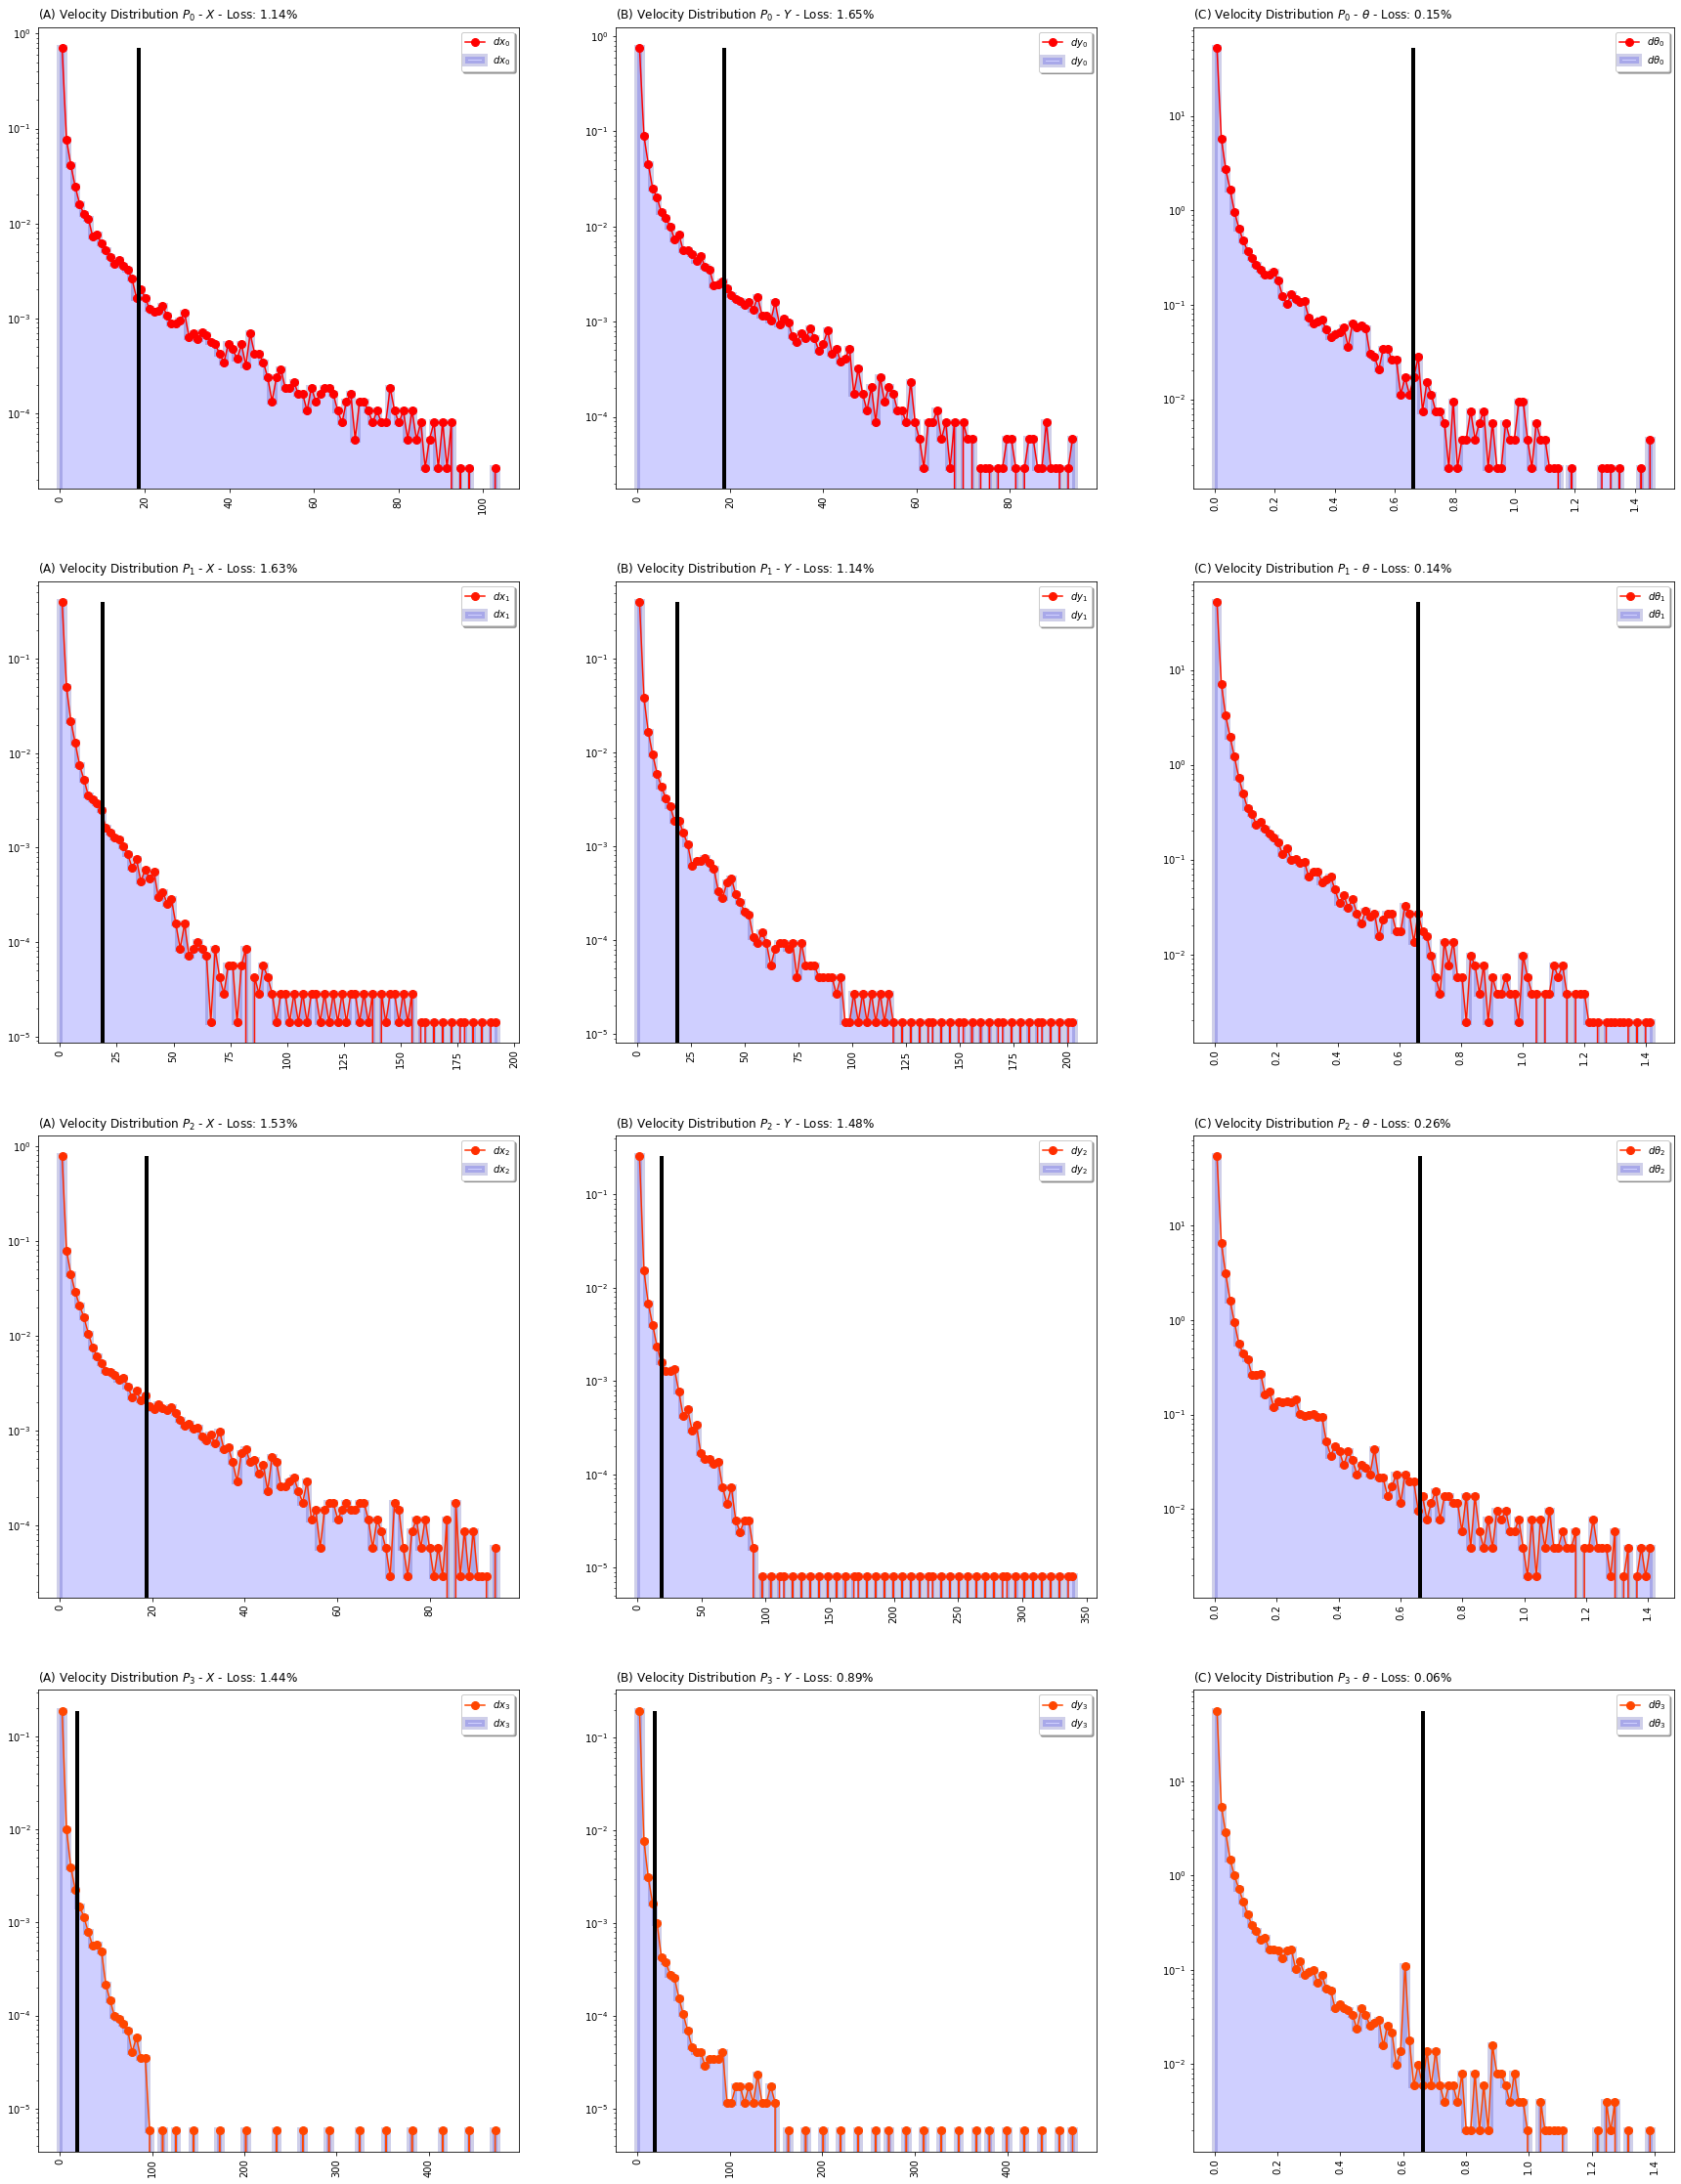

In [11]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = df_full["velocity_orientation"].abs().quantile(0.9965) # Angular velocity per frame
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9701) # Velocity per frame limited with half average size of particle
    print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend
    )

Original


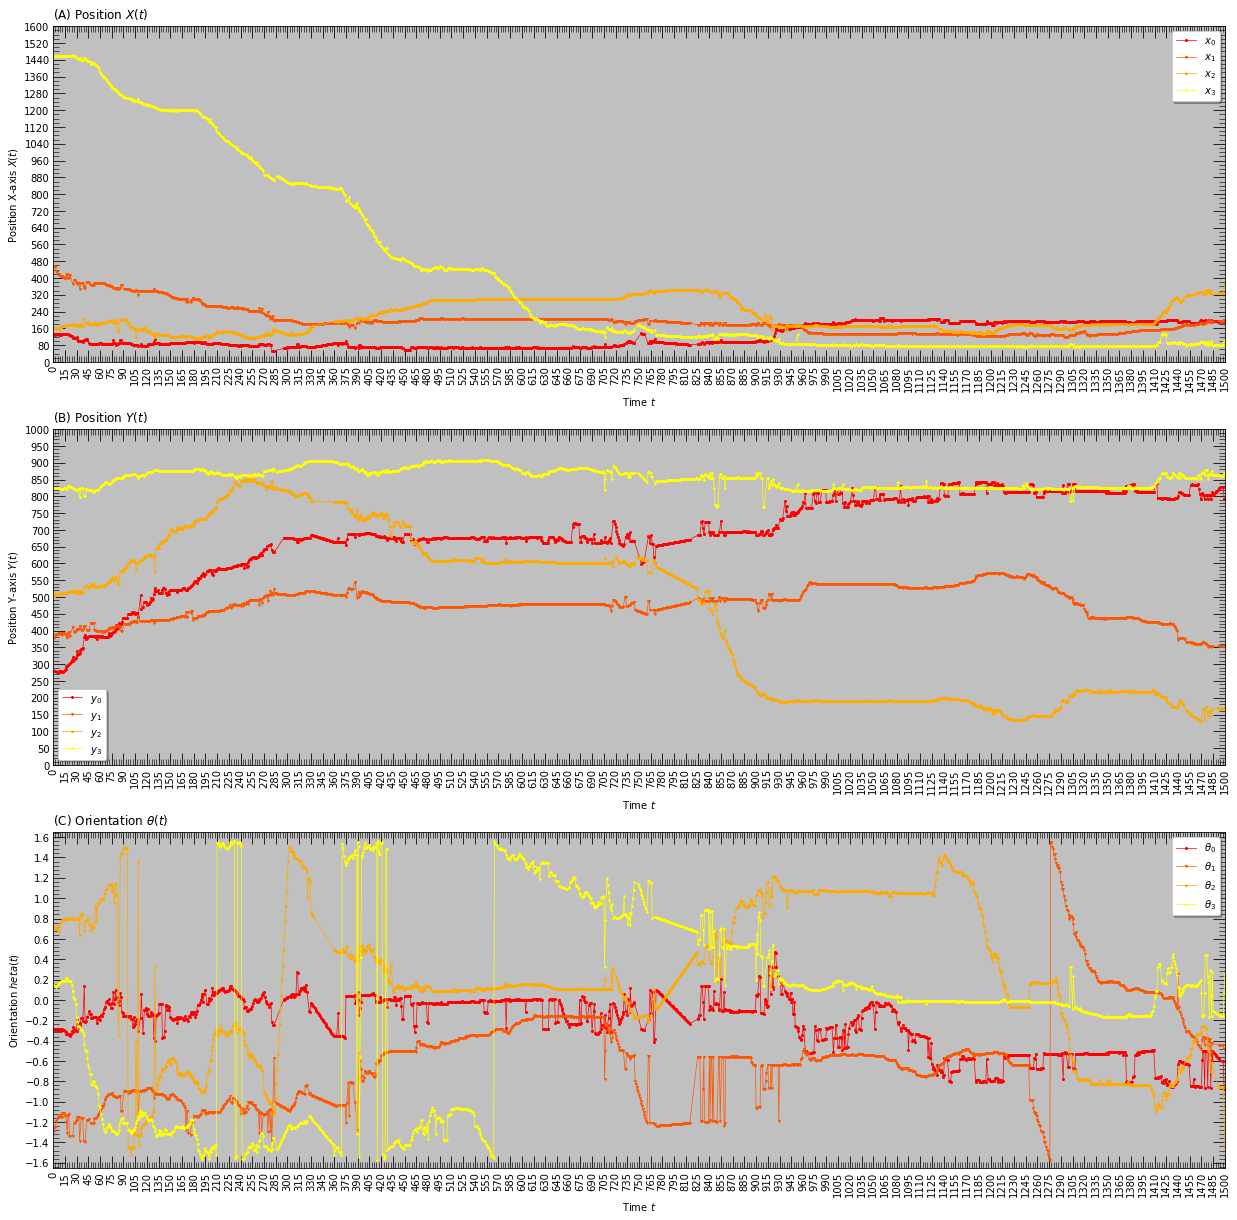

Corrected Orientation


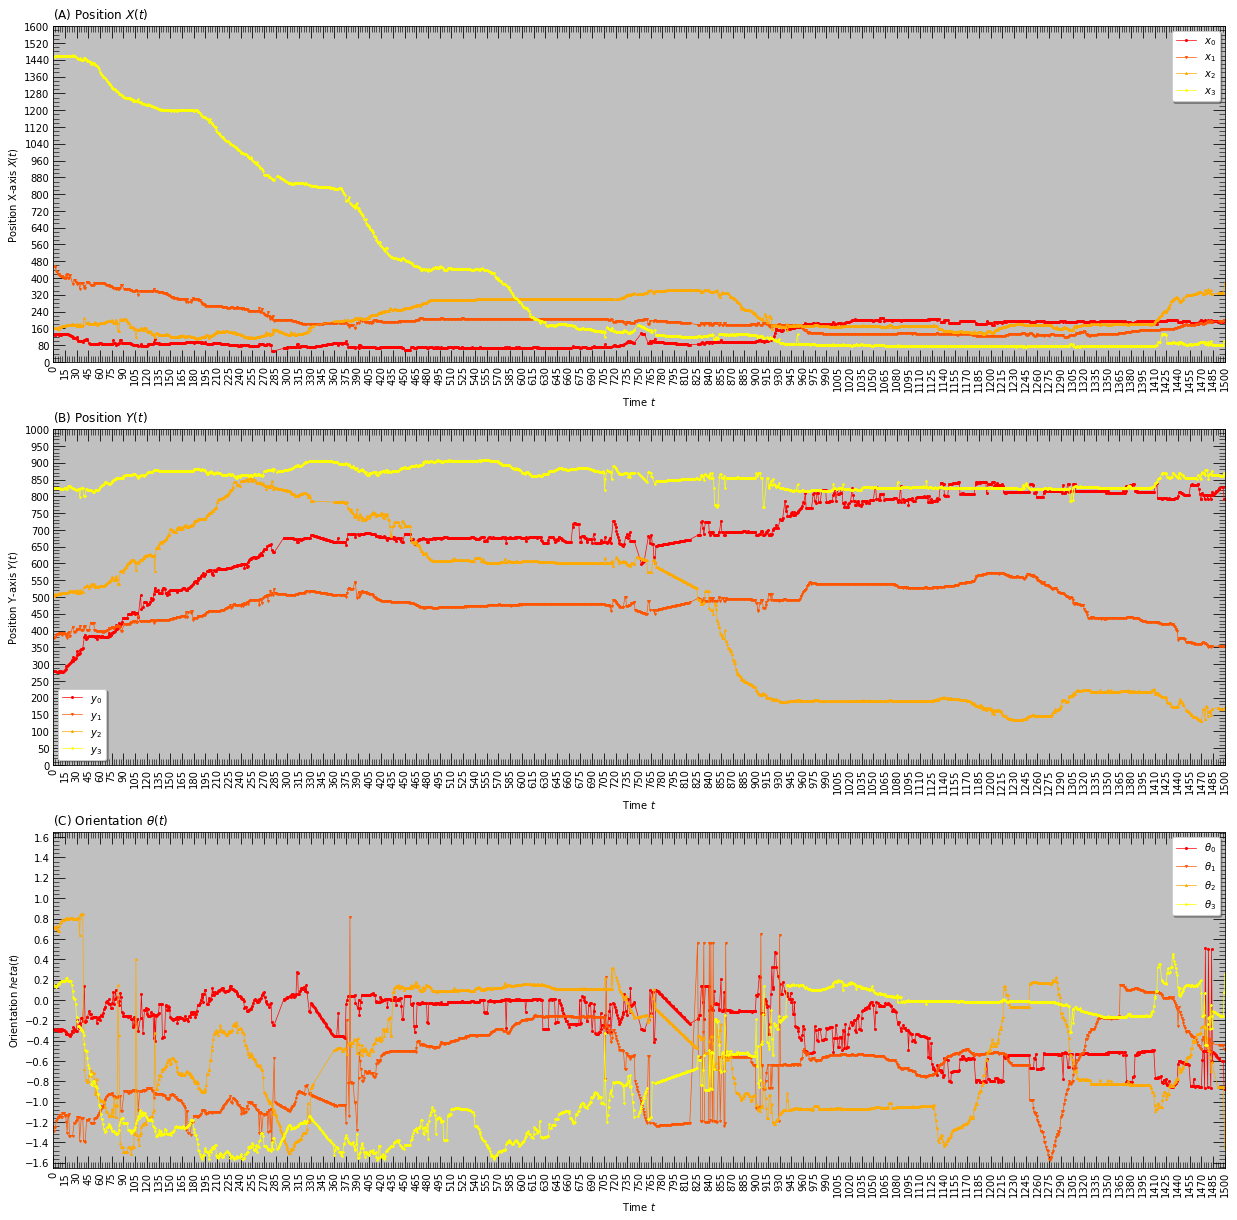

In [12]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf = 0, 1500
    t0_ = 12000
    tf_ = 14000
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1600], [0, 1000], [-1.65, 1.65]]
    fancy_legend = True

    print("Original")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9701) # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

    print("Corrected Orientation")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

In [13]:
df_smooth = df_full.copy()
df_smooth["id"] = df_smooth["permuted_id"]
print(np.cos(df_smooth[((df_smooth["time"] >= 208) & (df_smooth["time"] <= 210) & (df_smooth.permuted_id==3))]["orientation"].values))
print(np.sin(df_smooth[((df_smooth["time"] >= 208) & (df_smooth["time"] <= 210) & (df_smooth.permuted_id==3))]["orientation"].values))
df_smooth[((df_smooth["time"] >= 208) & (df_smooth["time"] <= 215) & (df_smooth.permuted_id==3))].sort_values(["permuted_id", "time"])

[0.14182946 0.04520319 0.03138033]
[-0.98989111 -0.99897781  0.99950752]


,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,area_convex,area_filled,axis_major,axis_minor,eccentricity,euler_number,id_count,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
835,True,208,chunk_00000_01695,3,3,1118.381358,868.571672,1108.475913,870.331312,0.0,1127.0,829.0,0.576471,1110.0,895.0,-1.428487,-1.428487,8218.0,10549.0,8247.0,169.530055,70.613276,0.909125,-45,4,-0.131397,0.017907,0.000358,False,False,False
839,True,209,chunk_00000_01695,3,3,1106.351152,868.348996,1094.655799,869.159253,0.0,1125.0,830.0,0.639216,1159.0,884.0,-1.525578,-1.525578,8811.0,11302.0,8837.0,179.709598,73.347773,0.912917,-47,4,-12.030206,-0.222676,-0.097091,False,False,False
843,True,210,chunk_00000_01695,3,3,1097.315930,871.004016,1085.450425,870.809795,0.0,1043.0,834.0,0.615686,1110.0,875.0,1.539411,-1.539411,8964.0,11353.0,8995.0,180.677938,74.160629,0.911880,-51,4,-9.035222,2.655020,0.013833,False,False,True
847,True,211,chunk_00000_01695,3,3,1093.483617,869.738865,1081.369803,869.640469,0.0,1105.0,832.0,0.619608,1022.0,882.0,1.551492,-1.551492,9003.0,11534.0,9025.0,181.014151,74.402506,0.911621,-49,4,-3.832314,-1.265151,0.012081,False,False,False
851,True,212,chunk_00000_01695,3,3,1089.848107,868.937076,1077.240671,868.607237,0.0,1042.0,832.0,0.788235,1137.0,879.0,1.529344,-1.529344,9138.0,11462.0,9211.0,182.351397,74.638497,0.912395,-50,4,-3.635510,-0.801789,-0.022148,False,False,False
855,True,213,chunk_00000_01695,3,3,1089.713423,869.046976,1076.892771,868.790689,0.0,1042.0,832.0,0.807843,1025.0,881.0,1.527399,-1.527399,9111.0,11378.0,9180.0,182.576706,74.307240,0.913432,-47,4,-0.134683,0.109900,-0.001945,False,False,False
859,True,214,chunk_00000_01695,3,3,1081.718412,869.011222,1066.740514,868.235923,0.0,1036.0,832.0,0.603922,1121.0,881.0,1.503485,-1.503485,9624.0,12138.0,9669.0,200.526114,72.861249,0.931653,-64,4,-7.995011,-0.035754,-0.023914,False,False,False
863,True,215,chunk_00000_01695,3,3,1076.159287,866.419947,1060.730908,865.717615,0.0,1036.0,828.0,0.611765,1160.0,872.0,1.516142,-1.516142,9756.0,12343.0,9776.0,203.258454,72.641553,0.933957,-49,4,-5.559126,-2.591275,0.012657,False,False,False


## Setting video information

In [14]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 90650
Frames resolution: 1080 x 1920


## Comparative of process

time: 208 id: 0 T: -63.3048 C: -63.3048 S:3.8934
time: 209 id: 0 T: -63.3913 C: -63.3913 S:4.1223
time: 210 id: 0 T: -63.3907 C: -63.3907 S:4.0459
time: 208 id: 1 T: 3.8934 C: 3.8934 S:-63.3048
time: 209 id: 1 T: 4.1223 C: 4.1223 S:-63.3913
time: 210 id: 1 T: 4.0459 C: 4.0459 S:-63.3907
time: 208 id: 2 T: -18.0377 C: -18.0377 S:-18.0377
time: 209 id: 2 T: -16.877 C: -16.877 S:-16.877
time: 210 id: 2 T: -18.5696 C: -18.5696 S:-18.5696
time: 208 id: 3 T: -81.8463 C: -81.8463 S:-81.8463
time: 209 id: 3 T: -87.4092 C: -87.4092 S:-87.4092
time: 210 id: 3 T: 88.2017 C: 88.2017 S:-88.2017


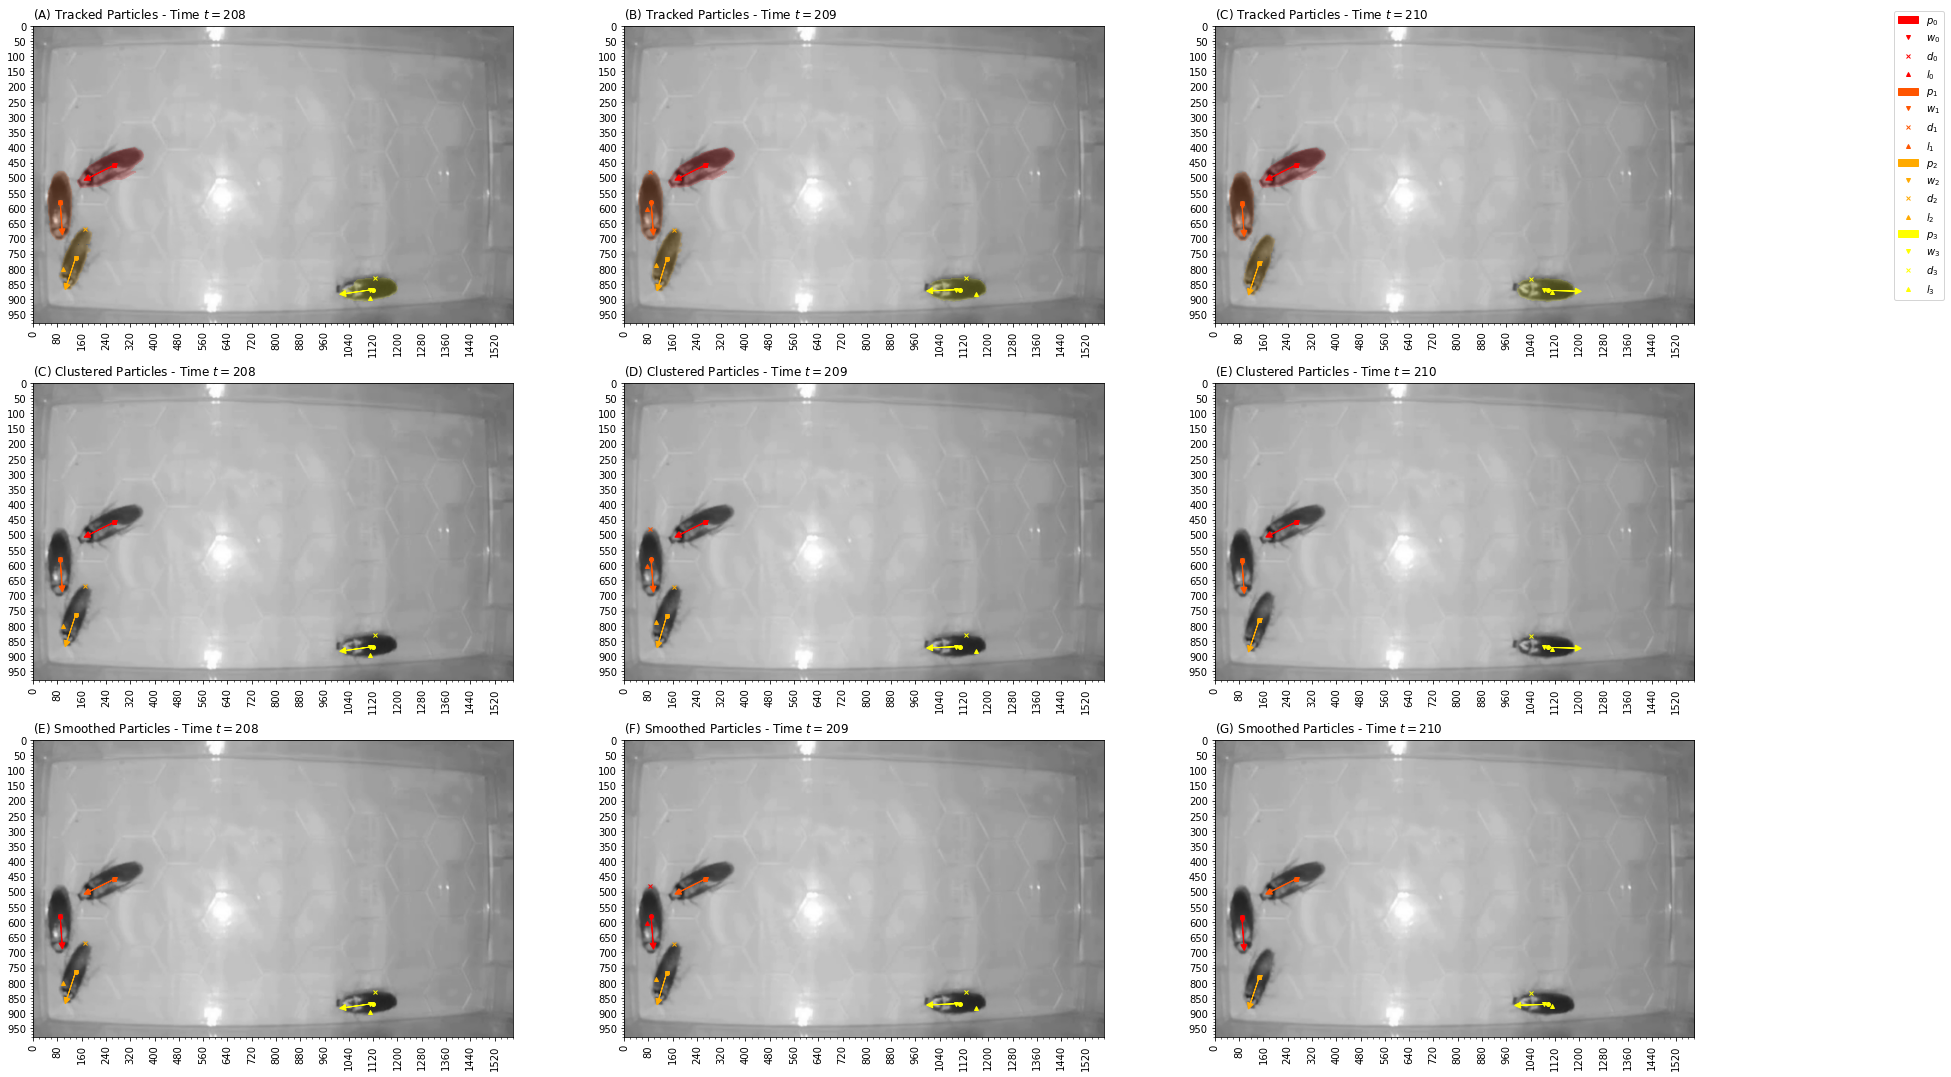

In [15]:
# Original frame
time = 209  #271  # 209  # 80
times = [time - 1, time, time + 1]
reinforce_boundaries = True
remove_holes = False
type = "local equalized"
clip_limit = 0.05
threshold = 0.19
sigma = 1.5
x_bounds = x_bounds  # [40, 1020]
y_bounds = y_bounds  # [160, 1740]
region_area_min = 200
axis_major_min = 94
eccentricity_max = 0.99


df_tracked_frame_0 = tp.process_frame(
    reinforce_boundaries=reinforce_boundaries,
    remove_holes=remove_holes,
    type=type,
    clip_limit=clip_limit,
    threshold=threshold,
    sigma=sigma,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    region_area_min=region_area_min,
    axis_major_min=axis_major_min,
    eccentricity_max=eccentricity_max,
    tracking_list=[times[0], reader.get_data(times[0])]
)

df_tracked_frame_1 = tp.process_frame(
    reinforce_boundaries=reinforce_boundaries,
    remove_holes=remove_holes,
    type=type,
    clip_limit=clip_limit,
    threshold=threshold,
    sigma=sigma,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    region_area_min=region_area_min,
    axis_major_min=axis_major_min,
    eccentricity_max=eccentricity_max,
    tracking_list=[times[1], reader.get_data(times[1])]
)

df_tracked_frame_2 = tp.process_frame(
    reinforce_boundaries=reinforce_boundaries,
    remove_holes=remove_holes,
    type=type,
    clip_limit=clip_limit,
    threshold=threshold,
    sigma=sigma,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    region_area_min=region_area_min,
    axis_major_min=axis_major_min,
    eccentricity_max=eccentricity_max,
    tracking_list=[times[2], reader.get_data(times[2])]
)

df_tracked_old = pd.concat([df_tracked_frame_0, df_tracked_frame_1, df_tracked_frame_2], ignore_index=True)

width = 10
n_x_breaks = 20
n_y_breaks = 20
fancy_legend = True
x_legend = 1.001
y_legend = 0.891

df_smooth = df_full.copy()
df_smooth["id"] = df_smooth["permuted_id"]
df_smooth["orientation"] = df_smooth["corrected_orientation"]

fig = plt_sp.plot_all_process_frame(
    reader=reader,
    times=times,
    df_tracked=df_tracked_old,
    df_clustered=df_tracked,
    df_smoothed=df_smooth,
    width=width,
    n_x_breaks=n_x_breaks,
    n_y_breaks=n_y_breaks,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    fancy_legend=fancy_legend,
    x_legend=x_legend,
    y_legend=y_legend
)

## TODO

In [ ]:
# Head - Bump Orientation (Postprocess using angle changes of interpolated data)
# Parallelize chunks of local smoothing (final merge)

time: 9999 id: 0 T: 70.9611 C: 70.9611 S:-69.4703
time: 10000 id: 0 T: 70.5548 C: 70.5548 S:-69.6181
time: 10001 id: 0 T: 70.4728 C: 70.4728 S:69.3687
time: 9999 id: 1 T: 1.4399 C: 1.4399 S:1.4399
time: 10000 id: 1 T: 1.5292 C: 1.5292 S:1.5292
time: 10001 id: 1 T: 3.0479 C: 3.0479 S:3.0479
time: 9999 id: 2 T: 69.4703 C: 69.4703 S:-66.2957
time: 10000 id: 2 T: 69.6181 C: 69.6181 S:-66.5179
time: 10001 id: 2 T: 69.3687 C: 69.3687 S:-66.5627
time: 9999 id: 3 T: -66.2957 C: -66.2957 S:-70.9611
time: 10000 id: 3 T: -66.5179 C: -66.5179 S:-70.5548
time: 10001 id: 3 T: -66.5627 C: -66.5627 S:70.4728


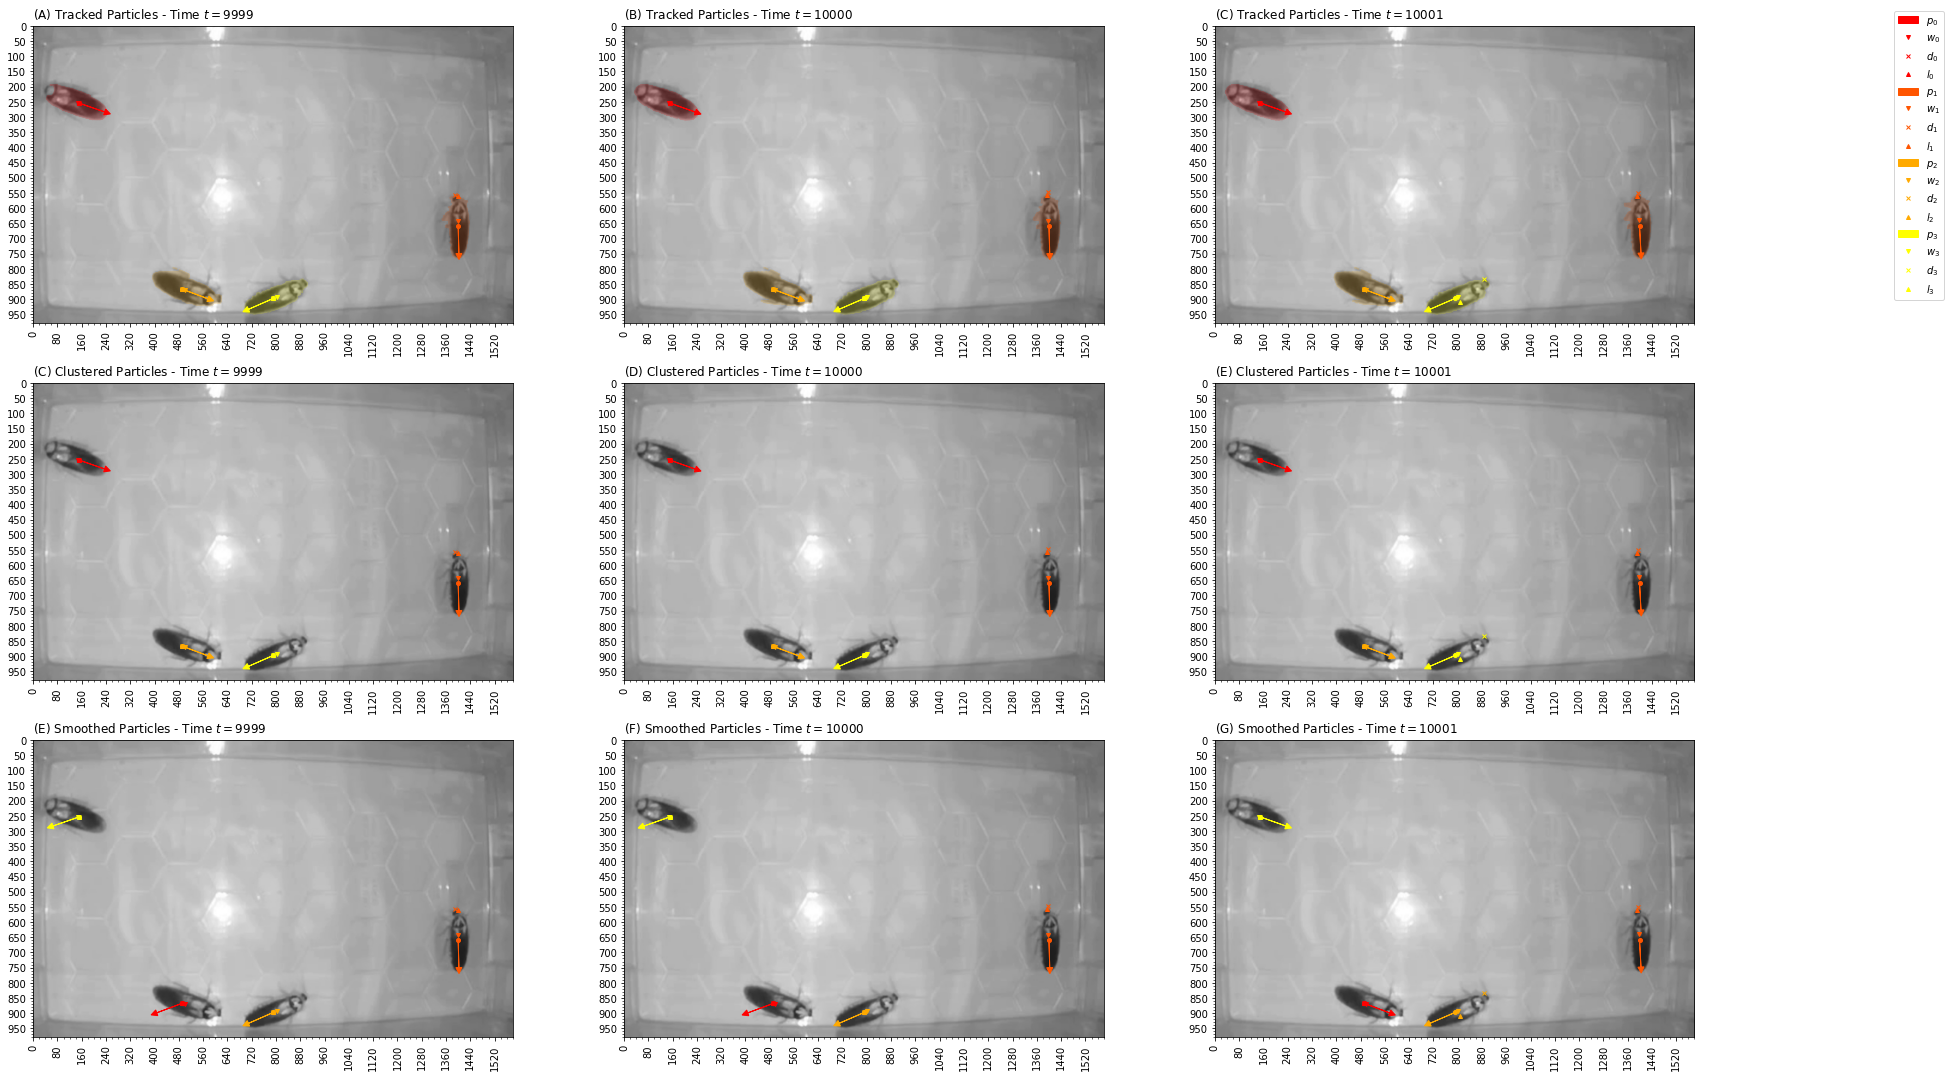

In [17]:
# Original frame
time = 10000  #271  # 209  # 80
times = [time - 1, time, time + 1]
reinforce_boundaries = True
remove_holes = False
type = "local equalized"
clip_limit = 0.05
threshold = 0.19
sigma = 1.5
x_bounds = x_bounds  # [40, 1020]
y_bounds = y_bounds  # [160, 1740]
region_area_min = 200
axis_major_min = 94
eccentricity_max = 0.99


df_tracked_frame_0 = tp.process_frame(
    reinforce_boundaries=reinforce_boundaries,
    remove_holes=remove_holes,
    type=type,
    clip_limit=clip_limit,
    threshold=threshold,
    sigma=sigma,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    region_area_min=region_area_min,
    axis_major_min=axis_major_min,
    eccentricity_max=eccentricity_max,
    tracking_list=[times[0], reader.get_data(times[0])]
)

df_tracked_frame_1 = tp.process_frame(
    reinforce_boundaries=reinforce_boundaries,
    remove_holes=remove_holes,
    type=type,
    clip_limit=clip_limit,
    threshold=threshold,
    sigma=sigma,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    region_area_min=region_area_min,
    axis_major_min=axis_major_min,
    eccentricity_max=eccentricity_max,
    tracking_list=[times[1], reader.get_data(times[1])]
)

df_tracked_frame_2 = tp.process_frame(
    reinforce_boundaries=reinforce_boundaries,
    remove_holes=remove_holes,
    type=type,
    clip_limit=clip_limit,
    threshold=threshold,
    sigma=sigma,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    region_area_min=region_area_min,
    axis_major_min=axis_major_min,
    eccentricity_max=eccentricity_max,
    tracking_list=[times[2], reader.get_data(times[2])]
)

df_tracked_old = pd.concat([df_tracked_frame_0, df_tracked_frame_1, df_tracked_frame_2], ignore_index=True)

width = 10
n_x_breaks = 20
n_y_breaks = 20
fancy_legend = True
x_legend = 1.001
y_legend = 0.891

from importlib import reload
reload(plt_sp)

df_smooth = df_full.copy()
df_smooth["id"] = df_smooth["permuted_id"]
df_smooth["orientation"] = df_smooth["corrected_orientation"]

fig = plt_sp.plot_all_process_frame(
    reader=reader,
    times=times,
    df_tracked=df_tracked_old,
    df_clustered=df_tracked,
    df_smoothed=df_smooth,
    width=width,
    n_x_breaks=n_x_breaks,
    n_y_breaks=n_y_breaks,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    fancy_legend=fancy_legend,
    x_legend=x_legend,
    y_legend=y_legend
)